In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.utils as utils
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [3]:
# Create custom dataset
class TrainDatasetP1(Dataset):
    def __init__(self, inputPath, resize=224, transform=None):
        self.inputPath = inputPath
        self.inputName = sorted(os.listdir(inputPath))
        self.transform = transforms.Compose([
            transforms.Resize((resize,resize)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            # transforms.RandomCrop((200,200)),
            transforms.ToTensor()
        ])
        
    def __getitem__(self, index):
        inputImage = Image.open(os.path.join(self.inputPath, self.inputName[index]))
        
        resize = transforms.Resize(size=(230,230))
        inputImage = resize(inputImage)
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            inputImage, output_size=(224,224)
        )
        inputImage = TF.crop(inputImage, i, j, h, w)
        
        label = int(self.inputName[index].split('_')[0])
        inputImage = self.transform(inputImage)
        return inputImage, label

    def __len__(self):
        return len(self.inputName)
    
class EvalDataset(Dataset):
    def __init__(self, inputPath, resize=224):
        self.inputPath = inputPath
        self.inputName = sorted(os.listdir(inputPath))
        self.transform = transforms.Compose([
            transforms.Resize((resize,resize)),
            transforms.ToTensor()
        ])
        
    def __getitem__(self, index):
        inputImage = Image.open(os.path.join(self.inputPath, self.inputName[index]))
        label = int(self.inputName[index].split('_')[0])
        inputImage = self.transform(inputImage)
        return inputImage, label

    def __len__(self):
        return len(self.inputName)
        

In [4]:
trainsetP1 = TrainDatasetP1(inputPath='/data/dlcv/hw1/hw1_data/p1_data/train_50', resize=224)
valsetP1 = EvalDataset(inputPath='/data/dlcv/hw1/hw1_data/p1_data/val_50', resize=224)

print('# images in trainset:', len(trainsetP1))
print('# images in valset', len(valsetP1))

# images in trainset: 22500
# images in valset 2500


In [5]:
print('Loading dataset ...')
loaderTrainsetP1 = DataLoader(dataset=trainsetP1, batch_size=128, shuffle=True, num_workers=4)
loaderValsetP1 = DataLoader(dataset=valsetP1, batch_size=1, shuffle=False, num_workers=0)

dataiter = iter(loaderTrainsetP1)
images, labels = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)

Loading dataset ...
Image tensor in each batch: torch.Size([128, 3, 224, 224]) torch.float32
Label tensor in each batch: torch.Size([128]) torch.int64


Labels:
tensor(5) tensor(49) tensor(47) tensor(41) tensor(44) tensor(17) tensor(15) tensor(27) tensor(36) tensor(40) tensor(12) tensor(11) tensor(35) tensor(39) tensor(11) tensor(40)
Device used: cuda


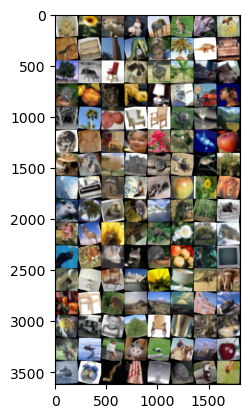

In [6]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:')
print(' '.join('%5s' % labels[j] for j in range(16)))

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.cuda.manual_seed(42)
device = torch.device("cuda" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

print('Device used:', device)


In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        lastsecondx = x.view(x.size(0), -1)
        x = self.fc(lastsecondx)

        return x, lastsecondx
    
ScratchModel = ResNet(ResidualBlock, [3,3,6,3], num_classes=50).to(device)
print(ScratchModel)


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [19]:
# trainning
def trainP1(model, epochs, log_interval=100):
    # model = torch.nn.DataParallel(model).to(device)
    model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = MultiStepLR(optimizer, milestones=[30,50,80], gamma=0.2)
    entropyLoss = nn.CrossEntropyLoss()
    iter = 0
    for epoch in range(epochs):
        # scheduler.step(epoch)
        for param_group in optimizer.param_groups:
            print('learning rate %f' % param_group["lr"])
        Loss = 0
        for i, (data, target) in enumerate(loaderTrainsetP1, 0):
            model.train()
            model.zero_grad()
            optimizer.zero_grad()
            data = Variable(data)
            target = Variable(target)
            data, target = data.to(device), target.to(device)
            
            result,_ = model(data)
            result_class = torch.argmax(result, dim=1)
            error = (result_class != target).sum()
            
            loss = entropyLoss(result, target)
            Loss += loss.item()
            loss.backward()
            optimizer.step()
            if iter % log_interval == 0:
                
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(data), len(loaderTrainsetP1.dataset),
                    100. * i / len(loaderTrainsetP1), loss.item()))
            iter += 1
        scheduler.step()
        
        accuracy = eval(model)
        
        path_checkpoint = "./checkpoints/A_{}_epoch.pkl".format(epoch)
        if(accuracy >= 0):
            print('Save checkpoint......')
            print('accuracy =', accuracy)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, path_checkpoint
            )

def eval(model):
    print('Start eval....')
    criterion = nn.CrossEntropyLoss()
    model = model.cuda()
    model.eval()  # Important: set evaluation mode
    test_loss = 0
    acc = 0
    correct = 0
    with torch.no_grad(): # This will free the GPU memory used for back-prop
        for data, target in loaderValsetP1:
            model.eval()
            model.zero_grad()
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # resultClass = torch.argmax(output, dim=1)
            # acc += (resultClass == target).sum()

    test_loss /= len(loaderValsetP1.dataset)
    accuracy = correct/len(loaderValsetP1.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(loaderValsetP1.dataset),
        100. * correct / len(loaderValsetP1.dataset)))
    # print("acc rate: {}; acc: {}".format(float(acc)/float(len(loaderValsetP1.dataset)), acc))
    return accuracy


In [30]:
# Load Checkpoint
loadResModel = ResNet(ResidualBlock, [3,3,6,3], num_classes=50).to(device)
loadResOptimizer = optim.Adam(loadResModel.parameters(), lr=0.001)
PATH = "./checkpoints/A_90_epoch.pkl"
checkpoint = torch.load(PATH)
loadResModel.load_state_dict(checkpoint['model_state_dict'], strict=True)
loadResOptimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
loadResModel.eval()
out = None

def hook(module, input, output):
    global out
    out = output
    return out

loadResModel.layer3.register_forward_hook(hook)

test_predictions = []
test_targets = []
test_embeddings = torch.zeros((0, 50), dtype=torch.float32)

for data, target in loaderValsetP1:
    loadResModel.eval()
    loadResModel.zero_grad()
    data, target = data.to(device), target.to(device)
    output, _ = loadResModel(data)
    
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    test_predictions.extend(pred.detach().cpu().tolist())
    test_targets.extend(target.detach().cpu().tolist())
    test_embeddings = torch.cat((test_embeddings, output.detach().cpu()), 0)

test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)
test_predictions = np.array(test_predictions)
# train(loadModel, 50)
_ = eval(loadResModel)

Start eval....

Test set: Average loss: 1.5450, Accuracy: 1812/2500 (72.480%)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
# from torchvision.datasets import MNIST
# from visualization import ANN
# %matplotlib widget

/home/jhccc/anaconda3/envs/dlcv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jhccc/anaconda3/envs/dlcv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.001s...
[t-SNE] Computed neighbors for 2500 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 13.810064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.313835
[t-SNE] KL divergence after 1000 iterations: 1.575455


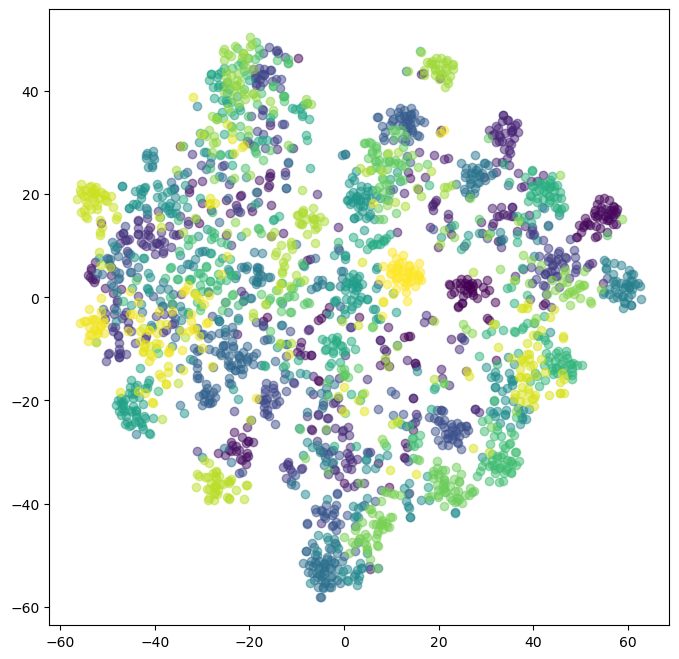

In [ ]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot pts as a scatter plot and label them based on the pred lables
cmap = cm.get_cmap('viridis',50)
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 50
for lab in range(num_categories):
    indices = [i for i, l in enumerate(test_predictions) if l == lab] # T/F array
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
# ax.legend(fontsize=5)
plt.show()

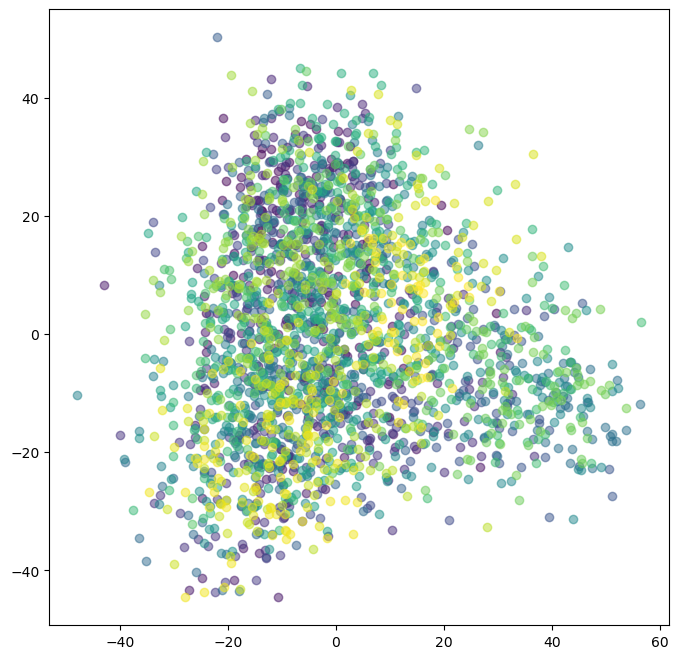

In [ ]:
pca = PCA(n_components=50)
pca.fit(test_embeddings)
pca_proj = pca.transform(test_embeddings)
pca.explained_variance_ratio_
cmap = cm.get_cmap('viridis',50)
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 50
for lab in range(num_categories):
    indices = [i for i, l in enumerate(test_predictions) if l == lab] # T/F array
    ax.scatter(pca_proj[indices,0],pca_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
# ax.legend(fontsize=5)
plt.show()


In [24]:
# trainning
def train(model, epochs, log_interval=100):
    # model = torch.nn.DataParallel(model).to(device)
    model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = MultiStepLR(optimizer, milestones=[30,50,80], gamma=0.2)
    entropyLoss = nn.CrossEntropyLoss()
    iter = 0
    for epoch in range(epochs):
        # scheduler.step(epoch)
        for param_group in optimizer.param_groups:
            print('learning rate %f' % param_group["lr"])
        Loss = 0
        for i, (data, target) in enumerate(loaderTrainsetP1, 0):
            model.train()
            model.zero_grad()
            optimizer.zero_grad()
            data = Variable(data)
            target = Variable(target)
            data, target = data.to(device), target.to(device)
            
            result = model(data)
            result_class = torch.argmax(result, dim=1)
            error = (result_class != target).sum()
            
            loss = entropyLoss(result, target)
            Loss += loss.item()
            loss.backward()
            optimizer.step()
            if iter % log_interval == 0:
                # print("epoch: {}; loss: {}; TotalLoss: {}; error: {}".format(epoch+1, loss.item(), Loss, error))
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(data), len(loaderTrainsetP1.dataset),
                    100. * i / len(loaderTrainsetP1), loss.item()))
            iter += 1
        scheduler.step()
        
        accuracy = eval(model)
        
        path_checkpoint86 = "./checkpoints/checkpointNew_{}_epoch.pkl".format(epoch)
        if(accuracy >= 0.86):
            print('Save checkpoint......')
            print('accuracy =', accuracy)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, path_checkpoint86
            )

def eval(model):
    print('Start eval....')
    criterion = nn.CrossEntropyLoss()
    model = model.cuda()
    model.eval()  # Important: set evaluation mode
    test_loss = 0
    acc = 0
    correct = 0
    with torch.no_grad(): # This will free the GPU memory used for back-prop
        for data, target in loaderValsetP1:
            model.eval()
            model.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # resultClass = torch.argmax(output, dim=1)
            # acc += (resultClass == target).sum()

    test_loss /= len(loaderValsetP1.dataset)
    accuracy = correct/len(loaderValsetP1.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(loaderValsetP1.dataset),
        100. * correct / len(loaderValsetP1.dataset)))
    # print("acc rate: {}; acc: {}".format(float(acc)/float(len(loaderValsetP1.dataset)), acc))
    return accuracy

In [8]:
def GetModel(class_num = 50, pretrained=False):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT, progress=True)
    model.fc = nn.Sequential(
        nn.Linear(in_features=2048, out_features=class_num, bias=True),
    )
    return model

class_model = GetModel(class_num=50, pretrained=True)
# train(class_model, 100)
# print(class_model)

In [9]:
# Load Checkpoint
loadModel = GetModel(50, False)
loadOptimizer = optim.Adam(loadModel.parameters(), lr=0.001)
PATH = "./checkpoints/checkpointNew_89_epoch.pkl"
checkpoint = torch.load(PATH)
loadModel.load_state_dict(checkpoint['model_state_dict'], strict=True)
loadOptimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
loadModel.eval()
# train(loadModel, 50)
_ = eval(loadModel)


Start eval....

Test set: Average loss: 0.8073, Accuracy: 2171/2500 (86.840%)

